# Vanilla 2

WORKS PERFECT!!

In [1]:
import random
import numpy as np
import seaborn as sns
import cv2
import time
import datetime
from dataclasses import dataclass
from enum import IntEnum
from matplotlib import pyplot as plt
from PIL import Image

In [2]:

    

"""
"""
@dataclass
class Rewards:
    base_reward: int
    obstacle_reward: int
    food_reward: int
        
    def __post_init__(self):
        assert self.food_reward > 0, "Food reward must be positive"
        assert self.obstacle_reward < 0, "Obstacle penalty must be negative"
        
        
        
"""
Represents a transition from one state to another.
The class contains both the old and the new state after the transition,
the reward claimed after having moved and the action taken
"""
@dataclass
class Transition:
    oldstate: tuple
    newstate: tuple
    reward: int
    action: str


        
"""
"""
class QSettings:
    def __init__(self, epochs: int, epsilon_stop_percentage: float = 0.8, discount: float = 0.95, learning_rate: float = 0.1, epsilon: float = 0.998, stats_every: int = -1, maxiterations: int = 1000):
        assert isinstance(epochs, int), f"Number of epochs must be an integer, not {type(epochs)}"
        self.epochs = epochs
        self.discount = discount
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_stop_percentage = epsilon_stop_percentage
        if stats_every == -1:
            self.stats_every = int(0.05 * self.epochs)
        else:
            self.stats_every = stats_every
        self.maxiterations = maxiterations
        
        self.epsilon_start_decaying = 1
        self.epsilon_end_decaying = int(self.epsilon_stop_percentage * self.epochs)
        self.epsilon_decay_value = self.epsilon / (self.epsilon_end_decaying - self.epsilon_start_decaying)

        
""""""
class EpochStats:
    def __init__(self, size: int, epoch: int, epsilon: float, start_position: tuple):
        # At start
        self.start_time = time.time()
        self.start_position = start_position
        self.epoch = epoch
        self.epsilon = epsilon
        # At runtime
        self.iterations = 0
        self.path = []
        self.path.append(self.start_position)
        self.steps_taken = np.zeros(shape=(size,size))
        self.steps_taken[start_position[0], start_position[1]] += 1
        self.penalties_given = 0
        self.average_rewards = []
        self.rewards = []
        self.actions = []
        self.end_state = None # Tuple to register endstate
        self.epochs_ended_for_max_iterations = 0
            
        
    def reset(self):
        pass
    
    def reached_goal(self, goal: tuple):
        if (self.end_state is not None):
            return goal == self.end_state
        else:
            raise ValueError("Asking for goal reach, but end state is not set")
    
    def add_step(self, transition: Transition):
        self.iterations += 1
        self.path.append(transition.newstate)
        self.steps_taken[transition.newstate[0], transition.newstate[1]] += 1
        self.rewards.append(transition.reward)
        self.average_rewards.append(sum(self.rewards) / self.iterations)
        self.actions.append(transition.action)
    
    def end_epoch(self, end_state: tuple):
        self.end_state = end_state
        self.end_time = time.time()
        duration_secs = self.end_time - self.start_time
        self.duration = str(datetime.timedelta(seconds=duration_secs))
        
    def add_max_iteration_reach(self):
        self.epochs_ended_for_max_iterations += 1
        
        
    
"""
"""
class TrainingResults:
    def __init__(self, epoch_stats: list, aggr_ep_rewards: dict):
        self.epoch_stats = epoch_stats
        self.aggregate_rewards = aggr_ep_rewards
    
    def total_time(self):
        return sum(s.duration_secs for s in self.epoch_stats)
    
    def total_iterations(self):
        return sum(s.iterations for s in self.epoch_stats) 
    
    def first_goal_reached(self, end_state: tuple):
        return next(s for s in self.epoch_stats if s.end_state == end_state)
    
    def epochs_reached_end_percentage(self, end_state: tuple):
        return float(len([e for e in self.epoch_stats if e.end_state == end_state]) / len(self.epoch_stats))
        

        
        
"""
"""        
class Environment:
    """Environment class constructor
    The constructor either takes one argument, or multiple positional arguments (kwargs).
    ...
    """
    def __init__(self, *args, **kwargs):
        if len(args) > 0:
            # If args are passed, then it must be a filename with the map
            # Check inputs
            assert len(kwargs)==0, "No positional arguments allowed if args are passed"
            assert len(args)==1, "Only one argument allowed: filename"
            map_filepath = args[0]
            assert isinstance(map_filepath, str), "Map filepath must be a string"
            # Build map
        else:
            self.__MIN_SIZE = 3
            assert len(kwargs) != 0, "Environment class does not have an empty contructor"
            VALID_KWARG_KEYS = ('size', 'end_position', 'nobstacles', 'rewards')
            MANDATORY_KWARG_KEYS = ('size')
            # Set passed kwargs
            for key in VALID_KWARG_KEYS:
                if key in kwargs:
                    setattr(self, key, kwargs[key])
                else:
                    if (key in MANDATORY_KWARG_KEYS):
                        raise ValueError(f"Positional argument {key} must be passed in Environment instance")
                    else:
                        setattr(self, key, None)
            if self.size < self.__MIN_SIZE:
                raise ValueError(f"Invalid size passed: {self.size}. Minimum value is {self.__MIN_SIZE}")
            self.cell_count = self.size * self.size
            
            if self.rewards is None:
                self.rewards = Rewards(base_reward=-1, obstacle_reward=-20, food_reward=400)
            
            # Check end location
            if self.end_position is None:
                self.end_position = tuple(np.random.randint(0, self.size, size=(2,)))
                    
            # Setup map
            self.obstacles = []
            if self.nobstacles is None:
                self.nobstacles = self.cell_count // 4
            else:
                if (self.nobstacles >= self.cell_count - 2):
                    raise ValueError(f"Too many obstacles passed: {self.nobstacles}. Cell count is {self.cell_count}")
            self.__build_obstacles()
            
            # Setup rewards
            self.reward_map = np.full(shape=(self.size, self.size), fill_value=self.rewards.base_reward)
            for obstacle in self.obstacles:
                self.reward_map[obstacle[0], obstacle[1]] = self.rewards.obstacle_reward
            self.reward_map[self.end_position[0], self.end_position[1]] = self.rewards.food_reward
            
    
    def __build_obstacles(self):
        if self.obstacles is None:
            self.obstacles = []
        if len(self.obstacles) > 0:
            return
        for i in range(self.nobstacles):
            while len(self.obstacles) < self.nobstacles:
                pos = tuple(np.random.randint(0, self.size, size=(2,)))
                if pos not in self.obstacles and pos != self.end_position:
                    self.obstacles.append(pos)
    def is_obstacle(self, *args):
        if len(args)==1:
            # Passed as state tuple
            assert isinstance(args[0], tuple)
            return args[0] in self.obstacles
        elif len(args)==2:
            # Passed as x, y integers
            assert isinstance(args[0], int)
            assert isinstance(args[1], int)
            return (args[0], args[1]) in self.obstacles
        else:
            raise ValueError(f"Obstacle checking allows a state or x,y parameters. Passing {len(args)} parameters is invalid")
    def is_end(self, *args):
        if len(args)==1:
            # Passed as state tuple
            assert isinstance(args[0], tuple)
            return args[0] == self.end_position
        elif len(args)==2:
            # Passed as x, y integers
            assert isinstance(args[0], int)
            assert isinstance(args[1], int)
            return (args[0], args[1]) == self.end_position
        else:
            raise ValueError(f"Obstacle checking allows a state or x,y parameters. Passing {len(args)} parameters is invalid")
    
    def show_map(self):
        img = self.get_reward_map_image()
        img = img.resize((1800, 1800))  # resizing so we can see our agent in all its glory.
        #cv2.imshow("image", np.array(img))  # show it!
        #cv2.waitKey(1)
        fig, ax = plt.subplots(figsize=(9,9))
        plt.title("Environment")
        plt.imshow(img)

    def get_reward_map_image(self, playerpos: tuple = None):
        env = np.zeros((self.size, self.size, 3), dtype=np.uint8)  # starts an rbg of our size
        for obstacle in self.obstacles:
            env[obstacle[0]][obstacle[1]] = (255, 0, 0)  # sets the enemy location to red
        if playerpos is not None:
            env[playerpos[0]][playerpos[1]] = (0, 0, 255)
        env[self.end_position[0]][self.end_position[1]] = (0, 255, 0)  # sets the food location tile to green color
        img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
        return img
    
    def show_path(self, path: list):
        img = self.__get_path_image(path)
        img = img.resize((1800, 1800))  # resizing so we can see our agent in all its glory.
        #cv2.imshow("image", np.array(img))  # show it!
        #cv2.waitKey(1)
        fig, ax = plt.subplots(figsize=(9,9))
        plt.title("Path")
        plt.imshow(img)
        
    def __get_path_image(self, path: list):
        env = np.zeros((self.size, self.size, 3), dtype=np.uint8)  # starts an rbg of our size
        for obstacle in self.obstacles:
            env[obstacle[0]][obstacle[1]] = (255, 0, 0)  # sets the enemy location to red
        for tile in path:
            env[tile[0]][tile[1]] = (0, 0, 255)
        env[self.end_position[0]][self.end_position[1]] = (0, 255, 0)  # sets the food location tile to green color
        img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
        return img
    
    
class QAgent:
    def __init__(self, env: Environment, start_position: tuple = None, qsettings: QSettings = None, verbose: bool = False):
        self.env = env
        if start_position is None:
            self.start_position = tuple(np.random.randint(0, self.env.size, shape=(2,)))
            while self.env.is_end(self.start_position) or self.env.is_obstacle(self.start_position):
                self.start_position = tuple(np.random.randint(0, self.env.size, shape=(2,)))
        else:
            if self.env.is_end(start_position) or self.env.is_obstacle(start_position):
                self.start_position = self.__find_nearby_start_position(start_position)
                if (self.start_position is None):
                    raise ValueError(f"QAgent starting position is invalid: {start_position}")
            self.start_position = start_position
            
        if qsettings is None:
            self.qsettings = QSettings(epochs=10000, stats_every=500)
        else:
            self.qsettings = qsettings
        self.actions = ['up', 'down', 'left', 'right']
        self.q_table = np.zeros([env.size, env.size, len(self.actions)])
        self.stats = None
        self.verbose = verbose
        
        self.state = self.start_position 
    
    def __move(self, action: int):
        # Take action
        x, y = self.state
        if (action == 0):
            next_state = (x-1, y)
        elif (action == 1):
            next_state = (x+1, y)
        elif (action == 2):
            next_state = (x, y-1)
        elif (action == 3):
            next_state = (x, y+1)
        else:
            raise ValueError("Received unknown action. Should never happen")
        # Check if new state is in valid position
        if (next_state[0] < 0 or next_state[0] > self.env.size - 1 or next_state[1] < 0 or next_state[1] > self.env.size - 1):
            #print("Invalid step taken: ", (x,y), " - wanted to go to: ",next_state)
            next_state = (x,y)
        return next_state
    
    def __find_nearby_start_position(self, s):
        pos = None
        neighbours = [(s[0]-1, s[1]), (s[0], s[1]-1), (s[0]+1, s[1]), (s[0], s[1]+1)]
        for n in neighbours:
            if self.env.is_end(n) or self.env.is_obstacle(n):
                continue
            else:
                pos = n
        return pos
                
        
    def make(self):
        pass

    def choose_action(self) -> int:
        # Choose action
        if random.uniform(0, 1) < self.get_epsilon():
            action = np.random.randint(0, len(self.actions))
        else:
            action = np.argmax(self.q_table[self.state[0], self.state[1]])
        return action
        
    def step(self, action: int):
        new_state = self.__move(action)
        reward = self.env.reward_map[new_state[0], new_state[1]]
        done = reward == self.env.rewards.food_reward or reward == self.env.rewards.obstacle_reward
        info = {}
        return new_state, reward, done, info
    
    def reset(self):
        self.state = self.start_position
    
    def get_epsilon(self):
        return self.qsettings.epsilon
    
    def train(self):
        aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': [], 'epsilon': []}
        epoch_overall_stats = []
        for epoch in range(self.qsettings.epochs):
            epoch_stats = EpochStats(size=self.env.size, epoch=epoch, epsilon=self.get_epsilon(), start_position=self.start_position)
            
            self.reset()
            done = False
            while not done:
                action_index = self.choose_action()
                newstate, reward, done, info = self.step(action_index)
                transition = Transition(oldstate= self.state, newstate = newstate, reward = reward, action=action_index)
                epoch_stats.add_step(transition)
                
                old_qvalue = self.q_table[self.state[0], self.state[1], action_index]
                next_max = np.max(self.q_table[newstate[0], newstate[1]])
                new_value = (1 - self.qsettings.learning_rate) * old_qvalue + self.qsettings.learning_rate * (reward + self.qsettings.discount * next_max)
                self.q_table[self.state[0], self.state[1], action_index] = new_value
                
                self.state = newstate
                
                if (epoch_stats.iterations == self.qsettings.maxiterations):
                    epoch_stats.add_max_iteration_reach()
                    break
                    
            # Post-epoch
            epoch_stats.end_epoch(newstate)
            epoch_overall_stats.append(epoch_stats)
            if not epoch % self.qsettings.stats_every:
                ep_rewards = [sum(e.rewards) for e in epoch_overall_stats]
                average_reward = sum(ep_rewards[-self.qsettings.stats_every:])/self.qsettings.stats_every
                aggr_ep_rewards['ep'].append(epoch)
                aggr_ep_rewards['avg'].append(average_reward)
                aggr_ep_rewards['max'].append(max(ep_rewards[-self.qsettings.stats_every:]))
                aggr_ep_rewards['min'].append(min(ep_rewards[-self.qsettings.stats_every:]))
            ## Print
                if self.verbose:
                    reached_goals_count = len([p for p in epoch_overall_stats if self.env.end_position in p.path])
                    print(f'Episode: {epoch:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {self.qsettings.epsilon:>1.2f}, reached goals: {reached_goals_count}, max interactions reached: {epoch_stats.epochs_ended_for_max_iterations}')
            if self.qsettings.epsilon_end_decaying >= epoch >= self.qsettings.epsilon_start_decaying:
                self.qsettings.epsilon -= self.qsettings.epsilon_decay_value        
        return TrainingResults(epoch_overall_stats, aggr_ep_rewards)

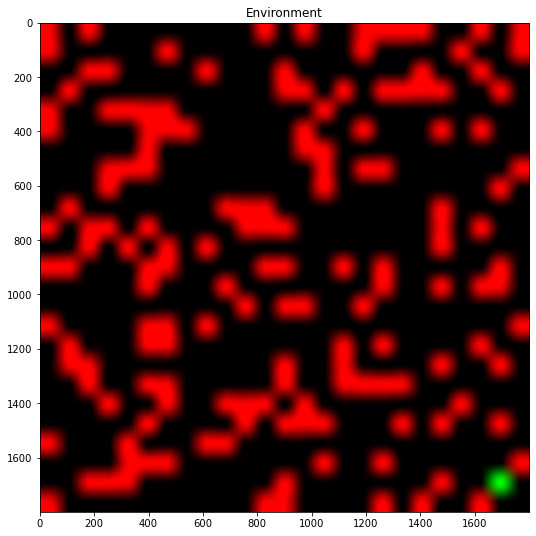

In [3]:
env = Environment(size=25, end_position=(23, 23))
env.show_map()

In [4]:
qsettings = QSettings(epochs=250000, discount=0.95, learning_rate=0.1)
agent = QAgent(env=env, start_position = (1,1), verbose=1, qsettings=qsettings)
results = agent.train()

Episode:     0, average reward: -0.0, current epsilon: 1.00, reached goals: 0, max interactions reached: 0
Episode: 12500, average reward: -22.2, current epsilon: 0.94, reached goals: 0, max interactions reached: 0
Episode: 25000, average reward: -22.5, current epsilon: 0.87, reached goals: 0, max interactions reached: 0
Episode: 37500, average reward: -22.9, current epsilon: 0.81, reached goals: 0, max interactions reached: 0
Episode: 50000, average reward: -23.4, current epsilon: 0.75, reached goals: 0, max interactions reached: 0
Episode: 62500, average reward: -24.0, current epsilon: 0.69, reached goals: 0, max interactions reached: 0
Episode: 75000, average reward: -24.6, current epsilon: 0.62, reached goals: 0, max interactions reached: 0
Episode: 87500, average reward: -25.7, current epsilon: 0.56, reached goals: 0, max interactions reached: 0
Episode: 100000, average reward: -26.9, current epsilon: 0.50, reached goals: 0, max interactions reached: 0
Episode: 112500, average rew

In [5]:
total_iterations = sum(c.iterations for c in results.epoch_stats)
total_penalties = sum(c.penalties_given for c in results.epoch_stats)

print(f"== Results after {agent.qsettings.epochs} epochs ==")
print(f"Total iterations: {total_iterations}")
print(f"Average timesteps per episode: {total_iterations / agent.qsettings.epochs}")
print(f"Average penalties per episode: {total_penalties / agent.qsettings.epochs}")

== Results after 250000 epochs ==
Total iterations: 4986893
Average timesteps per episode: 19.947572
Average penalties per episode: 0.0


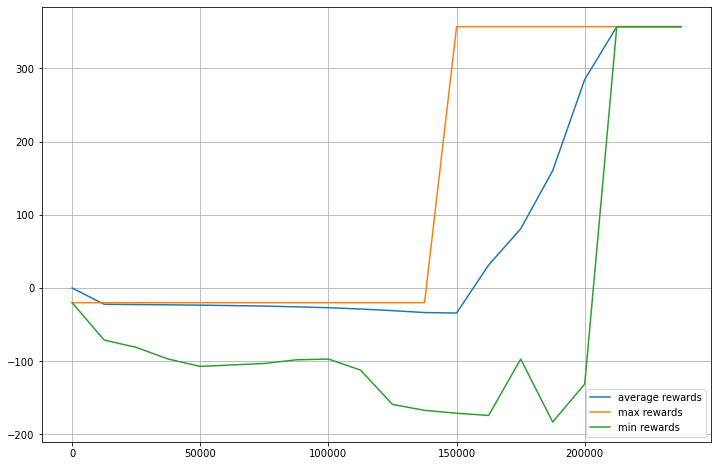

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(results.aggregate_rewards['ep'], results.aggregate_rewards['avg'], label="average rewards")
plt.plot(results.aggregate_rewards['ep'], results.aggregate_rewards['max'], label="max rewards")
plt.plot(results.aggregate_rewards['ep'], results.aggregate_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.grid(True)
plt.show()

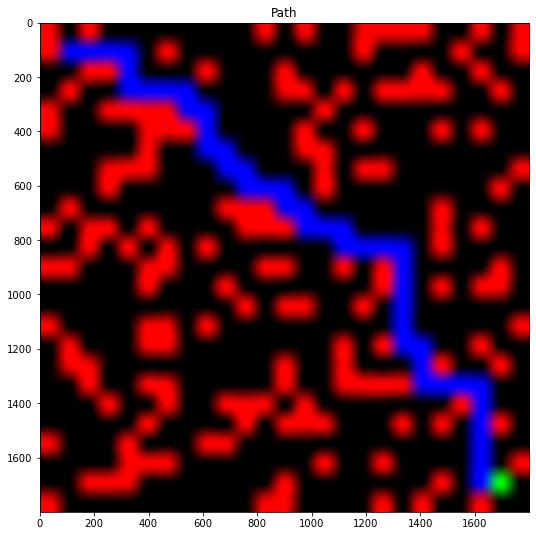

In [9]:
env.show_path(results.epoch_stats[-1].path)

###### Comments on the graph
The maximum reward is constantly at 0 for as long as the agent hasn't found the only source of positive reward: the food. Once the food is found, the agent knows where to find the good reward and always heads in that direction, and the rewards go up drastically.
Obviously, in the first steps the reward value decreases because each tile contains a small, negative reward to discourage long trips.

# Parameter analysis

### Discount

In [10]:
discount_values = [i/10 for i in range(1, 11)]
discount_stats_all = []
for i, discount in enumerate(discount_values):
    print(f"Iteration {i+1}/{len(discount_values)}", end="\r", flush=True)
    env = Environment(size=12, end_position=(10,10))
    agent = QAgent(env, start_position=(1,1))
    discount_aggr_res, discount_stats = agent.train()
    discount_stats_all.append(discount_stats)

KeyboardInterrupt: 

In [ ]:
print(discount_stats_all[0][0].rewards)